In [202]:
import random
import pandas as pd
import matplotlib.pyplot as plt

# Veri kümesini okuma
#data = pd.read_csv('./data/data1_food.csv', encoding='utf-8')
data = pd.read_csv('./data/data2_stweet.csv', encoding='utf-8')
#data = pd.read_csv('./data/data3_reddit.csv', encoding='utf-8')
#data = pd.read_csv('./data/data4_sarcasm.csv', encoding='utf-8')
#data = pd.read_csv('./data/data5_toxic.csv', encoding='utf-8')
data = data['text'].values.tolist()

# Etiketler
labels = [1]*50 + [0]*50

# Hazırlanan ilgili kelime kümesini okuma
with open("./vocabs/vocab2.txt", "r") as file:
    vocabulary = eval(file.readline())

# Rastgele 100 kelime içeren birey oluşturma
individual = [random.choice(vocabulary) for _ in range(100)]

# Fitness fonksiyonu
def fitness_(individual):
    correct = 0
    for i in range(len(data)):
        words = data[i].split()
        pos_count = 0
        neg_count = 0
        for word in words:
            if word in individual:
                index = individual.index(word)
                # Kelime, kelime kümesinin ilk 50 elemanı içindeyse pos_count değişkenini arttır
                if index < 50:
                    pos_count += 1
                # Kelime, kelime kümesinin son 50 elemanı içindeyse neg_count değişkenini arttır
                else:
                    neg_count += 1
        if pos_count > neg_count and labels[i] == 1:
            correct += 1
        elif pos_count < neg_count and labels[i] == 0:
            correct += 1
    return correct/len(data)


# Alternatif fitness --- F1 score, sonuçlarda daha iyi performans gösterdi
def fitness(individual):
    tp = 0  # true positive
    tn = 0  # true negative
    fp = 0  # false positive
    fn = 0  # false negative
    for i in range(len(data)):
        words = data[i].split()
        pos_count = 0
        neg_count = 0
        for word in words:
            if word in individual:
                index = individual.index(word)
                if index < 50:
                    pos_count += 1
                else:
                    neg_count += 1
        if pos_count > neg_count and labels[i] == 1:
            tp += 1
        elif pos_count < neg_count and labels[i] == 0:
            tn += 1
        elif pos_count > neg_count and labels[i] == 0:
            fp += 1
        elif pos_count < neg_count and labels[i] == 1:
            fn += 1
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    f1_score = 2 * precision * recall / (precision + recall + 1e-10)
    return round(f1_score, 2)


# population: Genetik algoritmanın kullanacağı bireylerin listesi.
# fitness_func: Bir bireyin uygunluğunu hesaplayan bir fonksiyon.
# weights: Bireylerin seçilme olasılıklarını belirleyen ağırlıkların listesi. Bu ağırlıklar, fitness fonksiyonunun bireysel değerleri ile oluşturulur.
# k: Seçilen bireylerin sayısı.
# individual1 ve individual2: Çaprazlama işlemine girecek olan iki birey.
# crossover_point: Çaprazlama işlemi sırasında belirlenen iki bireyin genlerinin birleştirileceği noktanın indis değeri.
# child1 ve child2: Yeni oluşturulan iki birey.
# mutation_point: Mutasyon işleminin uygulanacağı genin indis değeri.

# Seçilim
def selection(population, fitness_func):
    return random.choices(population, weights=[fitness_func(individual) for individual in population], k=len(population))

# Çaprazlama
def crossover(individual1, individual2):
    crossover_point = random.randint(1, len(individual1)-1)
    child1 = individual1[:crossover_point] + individual2[crossover_point:]
    child2 = individual2[:crossover_point] + individual1[crossover_point:]
    return child1, child2

# Mutasyon
def mutation(individual, vocabulary):
    mutation_point = random.randint(0, len(individual)-1)
    individual[mutation_point] = random.choice(vocabulary)
    return individual

# Genetik algoritma
def genetic_algorithm(population_size, max_generations, mutation_rate, crossover_rate, elitism):
    # Fitness değerlerini kaydetme listeleri
    best_fitnesses = [] # Tüm sonuçları toplu kaydetmek için ek liste olarak best-avg fitness değerlerini tutacağım.
    avg_fitnesses = []

    population = [individual.copy() for _ in range(population_size)]
    best_individual = max(population, key=fitness)
    best_fitness = fitness(best_individual)
    best_index = population.index(best_individual)

    for gen in range(max_generations):
        # Fitness değerlerini hesaplama ve kaydetme
        best_fitnesses.append(best_fitness)
        avg_fitnesses.append(sum(map(fitness, population)) / len(population))

        # Yeni nesil oluşturma
        new_population = [best_individual.copy()] # Yeni popülasyonu oluşturan bireylerin listesi
        while len(new_population) < population_size:
            parent1, parent2 = random.choices(population, weights=[fitness(individual) for individual in population], k=2)
            if random.random() < crossover_rate:
                child1, child2 = crossover(parent1, parent2)
                new_population.append(child1)
                new_population.append(child2)
            else:
                new_population.append(parent1)
                new_population.append(parent2)

        # Mutasyon
        for j in range(len(new_population)):
            if random.random() < mutation_rate:
                new_population[j] = mutation(new_population[j], vocabulary)

        # Fitness değerlerinin hesaplanması
        fitness_scores = [fitness(individual) for individual in new_population]

        # En iyi bireyin seçilmesi
        best_new_index = fitness_scores.index(max(fitness_scores))  # Yeni popülasyonun en iyi bireyinin indexi
        best_new_individual = new_population[best_new_index] # Yeni popülasyonun en iyi bireyi
        best_new_fitness = fitness(best_new_individual) # Yeni popülasyonun en iyi fitness değeri

        # Elitizm -> En iyi bireyin yeni nesile aktarılması: https://www.hypiostech.com/post/genetik-algoritma
        if elitism and best_new_fitness <= best_fitness:
            population = new_population
        else:
            population[best_index] = best_new_individual
            best_fitness = best_new_fitness
            best_individual = best_new_individual.copy()
            best_index = population.index(best_individual)

    # En iyi bireyi seçme
    best_individual = population[best_index]
    best_fitness = fitness(best_individual)
    best_fitnesses.append(best_fitness)

    return best_individual, best_fitness, best_fitnesses, avg_fitnesses

In [203]:
def save_figure(best_fitness, best_individual, best_fitnesses, avg_fitnesses, max_generations, population_size, mutation_rate, crossover_rate):
    #Sonuçları yazdırma
    print('\n\n\nMevcut Parametreler: [pop_size: {}, max_gen: {}, mut_rate: {}, cross_rate: {}], En iyi fitness değeri: {}, En iyi birey: "{}"'.format(population_size,max_generations,
                                                                                                     mutation_rate, crossover_rate,
                                                                                                     best_fitness, best_individual))
    print("\n")
    # Fitness grafiğini çizme
    plt.plot(best_fitnesses, label='En iyi fitness değeri')
    plt.plot(avg_fitnesses, label='Ortalama fitness değeri')
    plt.xlabel('Nesil')
    plt.ylabel('Fitness değeri')
    plt.legend()
    plt.savefig('./figures/pop_{}-gen_{}-mut_{}-cross_{}.png'.format(population_size, max_generations, mutation_rate, crossover_rate))
    plt.show()


def experiment(population_size, max_generations, mutation_rate, crossover_rate, elitism):

    pop_size = []
    max_gen = []
    mut_rate = []
    cross_rate = []
    best_individual_list = []
    best_fitness_list = []

    for size in population_size:
        for gen in max_generations:
            for mut in mutation_rate:
                for cross in crossover_rate:
                    # Genetik algoritmayı çalıştırma
                    best_individual, best_fitness, best_fitnesses, avg_fitnesses = genetic_algorithm(size, gen, mut, cross, elitism)
                    
                    pop_size.append(size)
                    max_gen.append(gen)
                    mut_rate.append(mut)
                    cross_rate.append(cross)
                    best_individual_list.append(best_individual)
                    best_fitness_list.append(best_fitness)
                    save_figure(best_fitness, best_individual, best_fitnesses, avg_fitnesses, gen, size, mut, cross)
    
    results = pd.DataFrame({'pop_size': pop_size, 'max_gen': max_gen, 'mutation_rate': mut_rate, 'crossover_rate':cross_rate,
                         'En iyi birey fitness değeri': best_fitness_list, 'En iyi birey': best_individual_list})
    
    results.to_excel('sarcasm_results_noElitism.xlsx', index=False, encoding='utf-8')




Mevcut Parametreler: [pop_size: 1, max_gen: 200, mut_rate: 0.2, cross_rate: 0.2], En iyi fitness değeri: 0.19, En iyi birey: "['priceless', 'exact', 'means', 'dies', 'falafel', 'possibility', 'adding', 'strange', 'lately', 'monomachos', 'conversation', 'eventually', 'similar', 'think', 'xanax', 'safarov', 'good', 'basic', 'material', 'creep', 'husband', 'sees', 'ethiopian', 'said', 'respect', 'yeah', 'angelos', 'together', 'power', 'britannica', 'waiting', 'poorly', 'армии', 'blind', 'jgoidug', 'threshold', 'imperial', 'indeed', 'concede', 'wikidefender', 'book', 'edits', 'happen', 'foreign', 'bitchen', 'tolerated', 'read', 'gradient', 'using', 'hang', 'pretty', 'dont', 'whether', 'anyway', 'grimm', 'calton', 'chop', 'product', 'statement', 'going', 'burn', 'minor', 'transport', 'directed', 'christ', 'english', 'argument', 'provided', 'dude', 'cases', 'non', 'last', 'lewis', 'obviously', 'liberty', 'iraq', 'hormonal', 'subject', 'hruegfigust', 'bomb', 'miserable', 'majorly', 'vandal

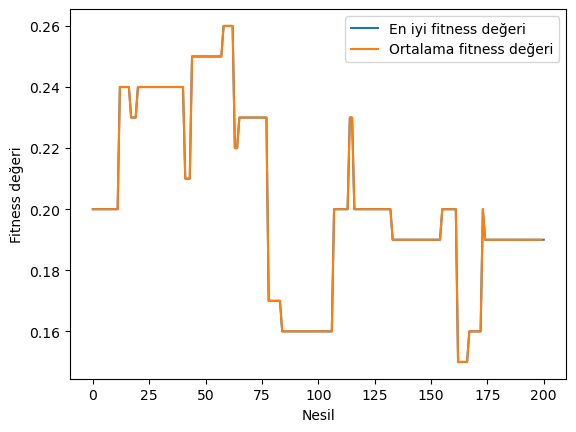




Mevcut Parametreler: [pop_size: 1, max_gen: 200, mut_rate: 0.2, cross_rate: 0.8], En iyi fitness değeri: 0.32, En iyi birey: "['almost', 'mackenzie', 'sure', 'count', 'toyeah', 'possibility', 'wpprominence', 'strange', 'comnenos', 'monomachos', 'politetrolling', 'eventually', 'suicide', 'prince', 'pejorative', 'танкового', 'capitalized', 'basic', 'rude', 'welfare', 'husband', 'sees', 'influences', 'added', 'magazine', 'theories', 'angelos', 'together', 'power', 'britannica', 'history', 'poorly', 'quotes', 'thats', 'jgoidug', 'according', 'imperial', 'quite', 'views', 'intercoarse', 'dribble', 'edits', 'storage', 'foreign', 'purely', 'forces', 'lots', 'gradient', 'roman', 'hang', 'birth', 'input', 'whether', 'anyway', 'grimm', 'calton', 'greeks', 'truce', 'quite', 'going', 'majorly', 'history', 'category', 'directed', 'easy', 'links', 'soviet', 'bizarre', 'simply', 'cases', 'government', 'attached', 'britannica', 'means', 'liberty', 'pile', 'dogs', 'subject', 'date', 'bomb', 'miserab

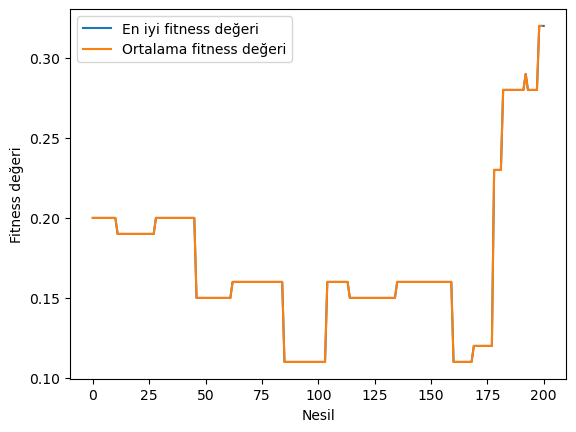




Mevcut Parametreler: [pop_size: 1, max_gen: 200, mut_rate: 0.8, cross_rate: 0.2], En iyi fitness değeri: 0.26, En iyi birey: "['referring', 'sources', 'follow', 'chance', 'prevalence', 'says', 'adding', 'forces', 'mussolini', 'rothwell', 'politetrolling', 'eventually', 'usually', 'train–train', 'flailing', 'productive', 'capitalized', 'megajoules', 'disruption', 'welfare', 'husband', 'foreign', 'expanded', 'hear', 'topic', 'theories', 'collaboratively', 'came', 'snake', 'britannica', 'list', 'boe', 'seems', 'joining', 'cells', 'thing', 'also', 'institution', 'concede', 'contact', 'read', 'edits', 'rain', 'warm', 'whenever', 'collaborative', 'wrong', 'competing', 'left', 'hang', 'burn', 'right', 'whether', 'sucks', 'thinking', 'epithets', 'available', 'primarily', 'ego', 'shit', 'relies', 'shared', 'granny', 'took', 'idiocy', 'issue', 'byzantine', 'provided', 'age', 'gay', 'format', 'fansite', 'lewis', 'bitter', 'liberty', 'fansite', 'maintains', 'kosovo', 'blocked', 'bomb', 'demonst

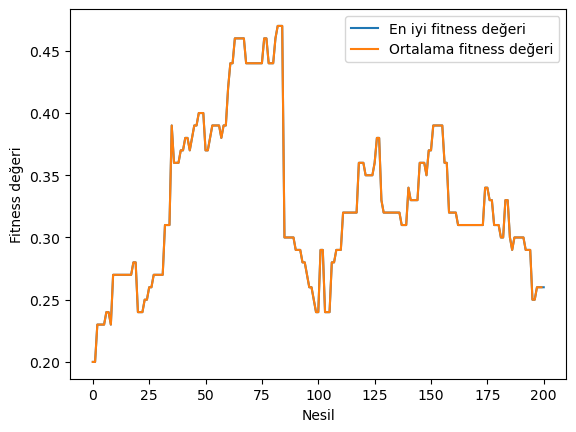




Mevcut Parametreler: [pop_size: 1, max_gen: 200, mut_rate: 0.8, cross_rate: 0.8], En iyi fitness değeri: 0.37, En iyi birey: "['moron', 'understand', 'fix', 'days', 'boisarchive', 'iswhat', 'clue', 'banning', 'produced', 'learned', 'djmasacre', 'армии', 'suicide', 'think', 'stupidity', 'connotations', 'current', 'basic', 'encyclopedia', 'nort', 'copy', 'stephen', 'idiot', 'trying', 'rated', 'whatever', 'bikkjuna', 'part', 'mamba', 'britannica', 'removing', 'blake', 'substance', 'wikiling', 'place', 'taskforce', 'religion', 'beutiful', 'encyclopedia', 'bit', 'book', 'determined', 'narmadensis', 'вышли', 'continue', 'age', 'thanks', 'albany', 'roman', 'please', 'torein–torein', 'rulessimplecomplex', 'bull', 'added', 'nicknameless', 'episode', 'seriously', 'across', 'putting', 'emo', 'epithets', 'luther', 'unverifiable', 'directed', 'easy', 'nonsense', 'bed', 'versions', 'hundreds', 'rag', 'describe', 'considered', 'personal', 'according', 'ani', 'offer', 'amended', 'seriously', 'hrueg

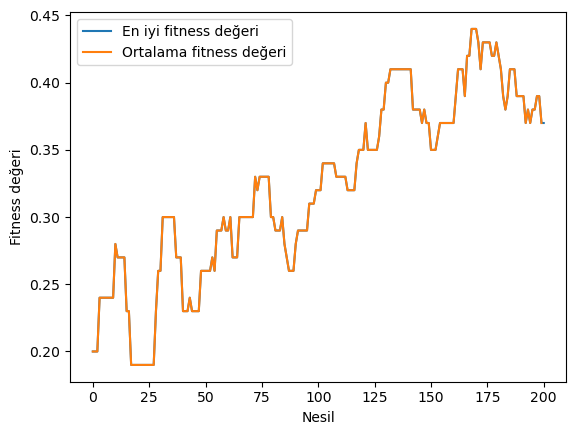




Mevcut Parametreler: [pop_size: 5, max_gen: 200, mut_rate: 0.2, cross_rate: 0.2], En iyi fitness değeri: 0.62, En iyi birey: "['almost', 'understand', 'dying', 'dies', 'firstly', 'musky', 'adding', 'армии', 'comnenos', 'turns', 'politetrolling', 'eventually', 'suicide', 'think', 'pejorative', 'танкового', 'capitalized', 'basic', 'precise', 'context', 'husband', 'sees', 'burn', 'kids', 'respect', 'life', 'previously', 'together', 'power', 'references', 'removing', 'poorly', 'армии', 'carrington', 'jgoidug', 'sculpture', 'imperial', 'indeed', 'concede', 'wikidefender', 'book', 'edits', 'circumstances', 'foreign', 'bitchen', 'tolerated', 'read', 'gradient', 'warning', 'hang', 'burn', 'input', 'fansite', 'anyway', 'grimm', 'calton', 'greeks', 'truce', 'quite', 'enough', 'jgiufd', 'edited', 'transport', 'directed', 'easy', 'treated', 'god', 'provided', 'dude', 'corruptibility', 'non', 'attached', 'definition', 'looks', 'liberty', 'room', 'dogs', 'principality', 'hruegfigust', 'fjhg', 'mi

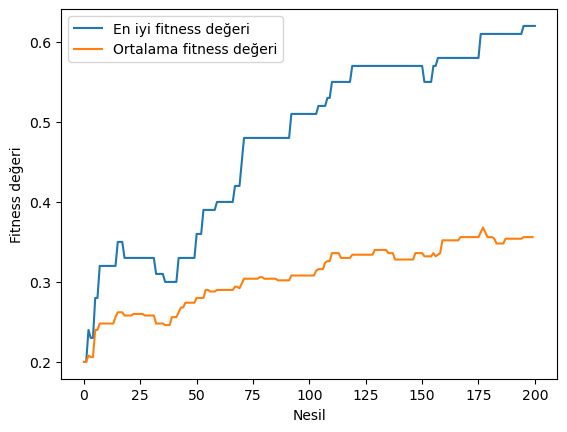




Mevcut Parametreler: [pop_size: 5, max_gen: 200, mut_rate: 0.2, cross_rate: 0.8], En iyi fitness değeri: 0.56, En iyi birey: "['almost', 'understand', 'dying', 'liberty', 'fucking', 'possibility', 'links', 'others', 'flagging', 'hoee', 'politetrolling', 'eventually', 'suicide', 'think', 'pejorative', 'танкового', 'capitalized', 'basic', 'axis', 'welfare', 'husband', 'sees', 'sit', 'woman', 'respect', 'theories', 'angelos', 'together', 'power', 'britannica', 'removing', 'poorly', 'армии', 'long', 'jgoidug', 'threshold', 'caption', 'indeed', 'concede', 'wikidefender', 'book', 'edits', 'political', 'george', 'bitchen', 'tolerated', 'enjoys', 'gradient', 'roman', 'baby', 'burn', 'arkansas', 'whether', 'anyway', 'join', 'towns', 'get', 'truce', 'quite', 'going', 'majorly', 'history', 'transport', 'directed', 'easy', 'links', 'cut', 'provided', 'dude', 'cases', 'non', 'attached', 'lewis', 'grief', 'liberty', 'coined', 'dogs', 'subject', 'hruegfigust', 'bomb', 'miserable', 'majorly', 'vand

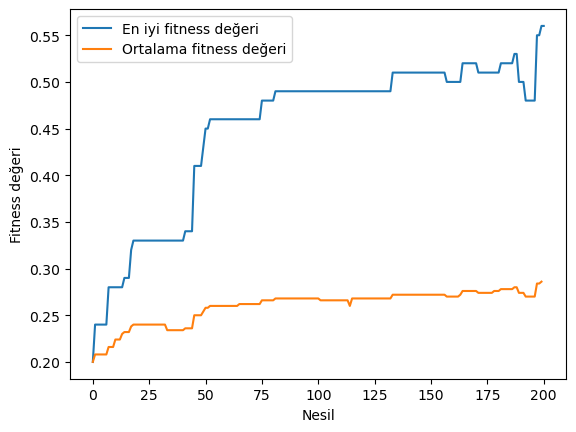




Mevcut Parametreler: [pop_size: 5, max_gen: 200, mut_rate: 0.8, cross_rate: 0.2], En iyi fitness değeri: 0.8, En iyi birey: "['nicknameless', 'hundreds', 'nazi', 'bitchy', 'falafel', 'chocolate', 'active', 'bars', 'lol', 'rudy', 'around', 'gibson', 'site', 'policy', 'colleges', 'rules', 'old', 'shove', 'attempting', 'welfare', 'useful', 'sees', 'housewives', 'heroes', 'try', 'theories', 'angelos', 'together', 'power', 'britannica', 'avoid', 'connotes', 'flag', 'shut', 'bicycle', 'threshold', 'imperial', 'action', 'shit', 'leaving', 'plug', 'edits', 'judge', 'support', 'вышли', 'suny', 'read', 'thing', 'army', 'stony', 'view', 'input', 'irtgyrehgui', 'making', 'include', 'variety', 'concede', 'war', 'quite', 'feed', 'similar', 'virgin', 'transport', 'come', 'talkdeepwater', 'links', 'swing', 'stalingrad', 'intro', 'committing', 'suicide', 'earth', 'writes', 'district', 'used', 'easy', 'dude', 'subject', 'nature', 'activists', 'halliday', 'blake', 'cutting', 'careful', 'ethiopian', 'l

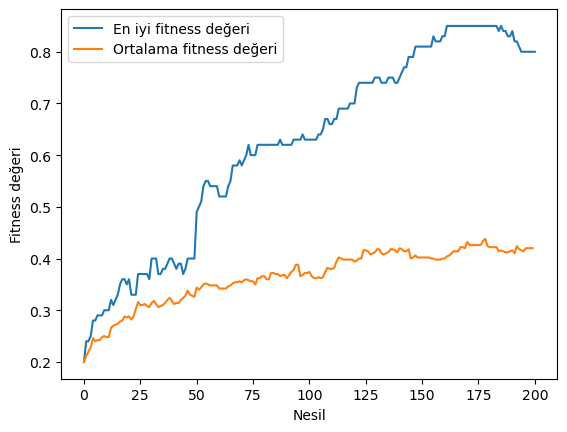




Mevcut Parametreler: [pop_size: 5, max_gen: 200, mut_rate: 0.8, cross_rate: 0.8], En iyi fitness değeri: 0.69, En iyi birey: "['summarize', 'understand', 'dying', 'dies', 'falafel', 'possibility', 'mother', 'erasing', 'comnenos', 'monomachos', 'politetrolling', 'patriarchy', 'suicide', 'agoian', 'pejorative', 'танкового', 'capitalized', 'cloud', 'rude', 'materialscientists', 'husband', 'offer', 'ethiopian', 'added', 'respect', 'theories', 'angelos', 'bearded', 'never', 'britannica', 'hruegfigust', 'poorly', 'xanax', 'thats', 'lot', 'motherfucker', 'field', 'interesting', 'getting', 'moi', 'fly', 'noncricket', 'fucking', 'song', 'demon', 'etujoijfgiosdug', 'bitter', 'next', 'recited', 'difference', 'formation', 'note', 'ash', 'removed', 'grimm', 'across', 'greeks', 'fifth', 'quite', 'call', 'proof', 'cutoff', 'schools', 'nature', 'poorly', 'fighting', 'deaths', 'find', 'dogshit', 'cases', 'non', 'attached', 'lewis', 'grief', 'stuff', 'pile', 'dogs', 'topics', 'outsmart', 'levels', 'h

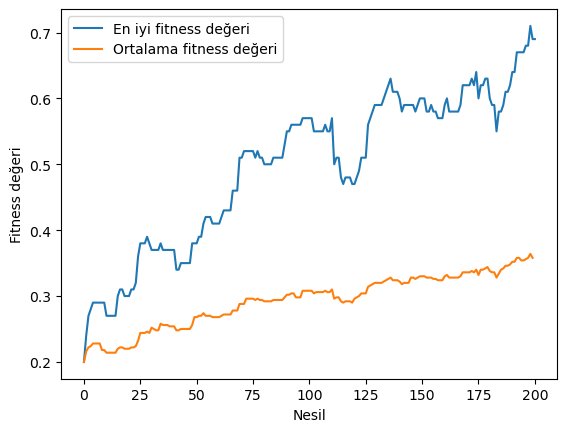




Mevcut Parametreler: [pop_size: 10, max_gen: 200, mut_rate: 0.2, cross_rate: 0.2], En iyi fitness değeri: 0.64, En iyi birey: "['ivan', 'understand', 'dying', 'dies', 'relations', 'possibility', 'adding', 'strange', 'comnenos', 'byzantine', 'assholes', 'eventually', 'suicide', 'kept', 'pejorative', 'танкового', 'capitalized', 'basic', 'rude', 'welfare', 'husband', 'paulus', 'ethiopian', 'mulidimensional', 'guidelines', 'figure', 'angelos', 'together', 'research', 'britannica', 'removing', 'selves', 'армии', 'thats', 'boat', 'threshold', 'dies', 'indeed', 'going', 'wikidefender', 'tiny', 'edits', 'sucks', 'foreign', 'bitchen', 'raumskulptur', 'read', 'gradient', 'roman', 'hang', 'burn', 'race', 'whether', 'anyway', 'pretty', 'calton', 'greeks', 'truce', 'quite', 'going', 'majorly', 'willeys', 'transport', 'directed', 'easy', 'unsigned', 'thanks', 'warnings', 'angelique', 'huge', 'definitely', 'attached', 'annoys', 'grief', 'hang', 'pile', 'dogs', 'subject', 'hruegfigust', 'back', 'mi

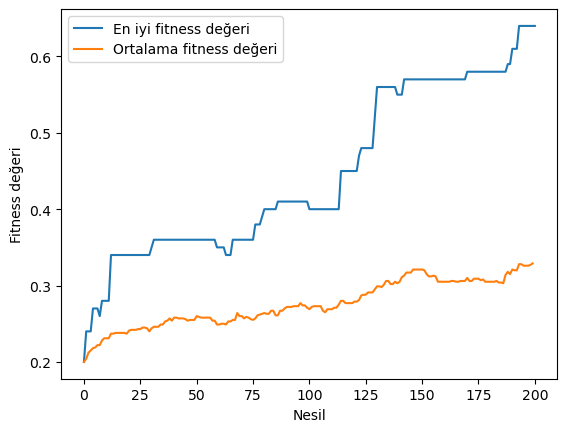




Mevcut Parametreler: [pop_size: 10, max_gen: 200, mut_rate: 0.2, cross_rate: 0.8], En iyi fitness değeri: 0.58, En iyi birey: "['almost', 'understand', 'lol', 'dies', 'falafel', 'possibility', 'adding', 'strange', 'comnenos', 'monomachos', 'politetrolling', 'eventually', 'watch', 'feedbacks', 'pejorative', 'танкового', 'capitalized', 'basic', 'rude', 'welfare', 'husband', 'sees', 'ethiopian', 'mortified', 'respect', 'theories', 'angelos', 'detail', 'power', 'lapp', 'removing', 'poorly', 'soul', 'thats', 'jgoidug', 'threshold', 'imperial', 'indeed', 'government', 'wikidefender', 'book', 'want', 'going', 'foreign', 'bitchen', 'serious', 'read', 'gradient', 'танкового', 'hang', 'burn', 'input', 'whether', 'transported', 'grimm', 'calton', 'trying', 'truce', 'quite', 'going', 'majorly', 'international', 'remove', 'directed', 'easy', 'links', 'deaths', 'morning', 'offer', 'cases', 'non', 'attached', 'lewis', 'fuel', 'generally', 'blind', 'dogs', 'recited', 'capitalized', 'bomb', 'miserab

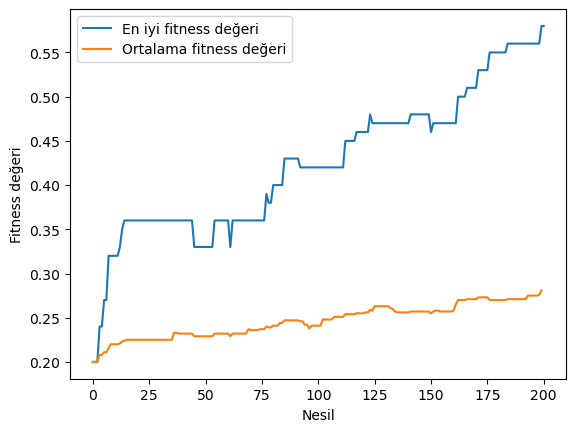




Mevcut Parametreler: [pop_size: 10, max_gen: 200, mut_rate: 0.8, cross_rate: 0.2], En iyi fitness değeri: 0.85, En iyi birey: "['sex', 'communicating', 'dying', 'dies', 'much', 'wrote', 'ramil', 'garbage', 'easily', 'homophobic', 'revision', 'buffoon', 'gasoline', 'think', 'lewis', 'picture', 'vampirefreakscom', 'basic', 'chart', 'penis', 'reactions', 'krngkfdjs', 'mussolini', 'added', 'anyone', 'concede', 'fuckboti', 'nonsense', 'ragu', 'idea', 'shame', 'horrible', 'times', 'hoped', 'novel', 'shut', 'five', 'shit', 'concede', 'missy', 'magic', 'satian', 'five', 'agressive', 'circumstances', 'tolerated', 'moi', 'examples', 'serene', 'вышли', 'assertions', 'besides', 'writes', 'anyway', 'femininity', 'virat', 'greeks', 'oldest', 'valid', 'examples', 'minor', 'feed', 'maynard', 'flailing', 'bonds', 'pages', 'maynard', 'provided', 'announcing', 'expanded', 'dicussion', 'uvg', 'discussion', 'grief', 'studies', 'definately', 'flood', 'танкового', 'hruegfigust', 'bomb', 'points', 'obseess

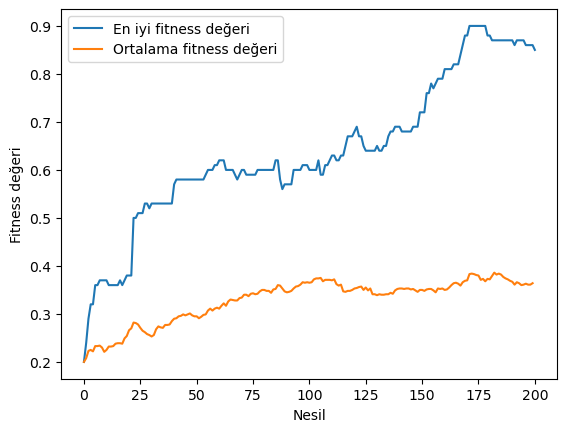




Mevcut Parametreler: [pop_size: 10, max_gen: 200, mut_rate: 0.8, cross_rate: 0.8], En iyi fitness değeri: 0.68, En iyi birey: "['almost', 'understand', 'till', 'dies', 'falafel', 'possibility', 'horizon', 'strange', 'learned', 'bomb', 'fun', 'knows', 'memory', 'ncaa', 'avoid', 'phd', 'threatening', 'basic', 'assisted', 'oldest', 'killed', 'byzantine', 'ethiopian', 'bit', 'slang', 'write', 'burn', 'suppose', 'problem', 'hang', 'syrian', 'poorly', 'sing', 'entry', 'watch', 'giuliani', 'imperial', 'note', 'wat', 'completely', 'nothing', 'corps', 'heat', 'mulidimensional', 'turns', 'stands', 'suggest', 'fan', 'tyr', 'eating', 'comnenos', 'new', 'whether', 'instance', 'grimm', 'useful', 'maximum', 'truce', 'argument', 'count', 'campus', 'history', 'accurate', 'directed', 'easy', 'links', 'circumstances', 'provided', 'dude', 'whiny', 'non', 'insulting', 'big', 'grief', 'liberty', 'spacial', 'dogs', 'subject', 'hruegfigust', 'bomb', 'miserable', 'majorly', 'waver', 'careful', 'longdead', '

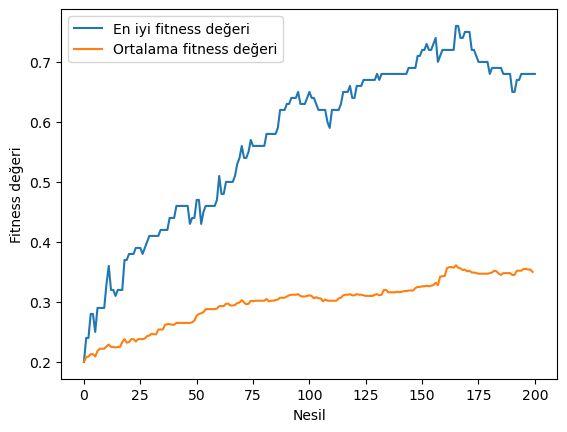




Mevcut Parametreler: [pop_size: 20, max_gen: 200, mut_rate: 0.2, cross_rate: 0.2], En iyi fitness değeri: 0.65, En iyi birey: "['almost', 'monomachos', 'dying', 'dies', 'falafel', 'possibility', 'cable', 'strange', 'supported', 'monomachos', 'politetrolling', 'bother', 'suicide', 'btw', 'unsigned', 'translates', 'capitalized', 'basic', 'rude', 'get', 'husband', 'sees', 'ethiopian', 'armenians', 'respect', 'boe', 'preety', 'together', 'rude', 'dan', 'removing', 'jtgnkjryt', 'shot', 'thats', 'jgoidug', 'stupid', 'imperial', 'indeed', 'concede', 'wikidefender', 'book', 'edits', 'political', 'foreign', 'bitchen', 'tolerated', 'read', 'gradient', 'roman', 'race', 'adding', 'input', 'failed', 'anyway', 'grimm', 'calton', 'greeks', 'truce', 'lenrcanrorg', 'categories', 'earse', 'history', 'transport', 'directed', 'easy', 'took', 'deaths', 'provided', 'necessarily', 'cases', 'york', 'attached', 'lewis', 'grief', 'liberty', 'plug', 'redirect', 'subject', 'hruegfigust', 'train—train', 'nonrew

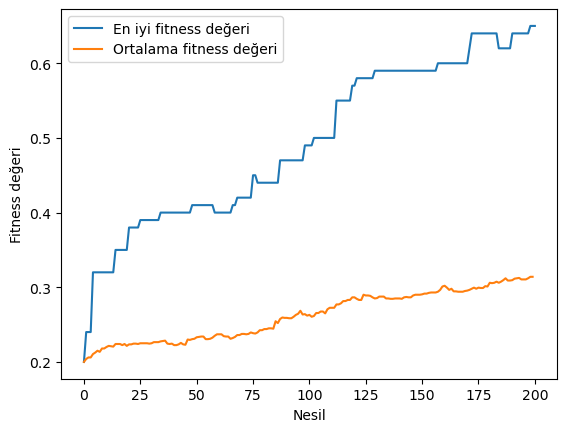




Mevcut Parametreler: [pop_size: 20, max_gen: 200, mut_rate: 0.2, cross_rate: 0.8], En iyi fitness değeri: 0.55, En iyi birey: "['almost', 'atrocity', 'dying', 'dies', 'invariably', 'cross', 'communism', 'greater', 'gets', 'monomachos', 'politetrolling', 'byzantine', 'suicide', 'detrimental', 'pejorative', 'танкового', 'product', 'basic', 'rude', 'someone', 'though', 'sees', 'word', 'snowflake', 'respect', 'women', 'angelos', 'together', 'calling', 'britannica', 'hiphop', 'samuel', 'washington', 'thats', 'jgoidug', 'threshold', 'imperial', 'indeed', 'concede', 'wikidefender', 'instead', 'purpose', 'political', 'inert', 'bitchen', 'bitch', 'read', 'zero', 'roman', 'hang', 'burn', 'input', 'whether', 'see', 'grimm', 'calton', 'greeks', 'truce', 'quite', 'everyday', 'majorly', 'authority', 'transport', 'directed', 'easy', 'links', 'deaths', 'provided', 'dude', 'cases', 'non', 'attached', 'lewis', 'continue', 'liberty', 'pile', 'dogs', 'fansite', 'hruegfigust', 'bomb', 'miserable', 'majo

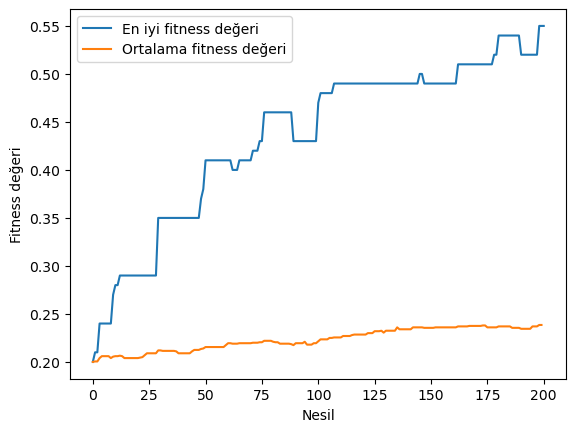




Mevcut Parametreler: [pop_size: 20, max_gen: 200, mut_rate: 0.8, cross_rate: 0.2], En iyi fitness değeri: 0.81, En iyi birey: "['vermont', 'understand', 'prove', 'always', 'gasoline', 'collaboratively', 'inup', 'bomb', 'fuel', 'like', 'politetrolling', 'terms', 'sign', 'think', 'obviously', 'selves', 'examples', 'despised', 'doormatt', 'skills', 'traits', 'jtgnkjryt', 'world', 'idea', 'respect', 'within', 'hearing', 'ruder', 'bull', 'cutoff', 'maynard', 'media', 'fuck', 'thats', 'love', 'idea', 'imperial', 'ego', 'natinoalists', 'lewis', 'respect', 'morning', 'quote', 'foreign', 'expert', 'stupid', 'arbitrary', 'important', 'size', 'kill', 'horizon', 'reflection', 'easily', 'mention', 'describing', 'ways', 'greeks', 'truce', 'quite', 'intention', 'map', 'quick', 'transport', 'ygoip', 'iryggoifhgo', 'german', 'deaths', 'diary', 'corps', 'cow', 'think', 'hes', 'reached', 'materialscientists', 'liberty', 'fourth', 'ideas', 'people', 'interest', 'language', 'condom', 'pages', 'dynasties

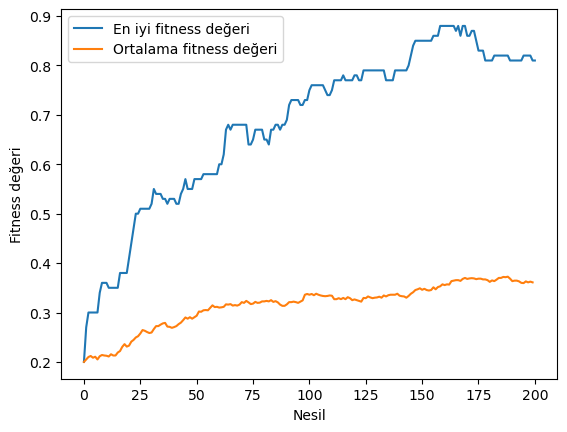




Mevcut Parametreler: [pop_size: 20, max_gen: 200, mut_rate: 0.8, cross_rate: 0.8], En iyi fitness değeri: 0.61, En iyi birey: "['almost', 'understand', 'dying', 'dies', 'suicide', 'eek', 'shot', 'september', 'ruder', 'groups', 'rated', 'eventually', 'lends', 'saw', 'pejorative', 'throughout', 'swing', 'fuckboti', 'rude', 'welfare', 'jgoidug', 'boe', 'tny', 'offencive', 'армии', 'notice', 'seriously', 'hacks', 'talking', 'false', 'bastards', 'irritating', 'instantlyi', 'treated', 'something', 'invariably', 'acted', 'thank', 'magazines', 'testing', 'rulessimplecomplex', 'bullshit', 'coward', 'changes', 'lebanon', 'economic', 'properly', 'gradient', 'contents', 'sufficiently', 'alternative', 'summary', 'whether', 'ratings', 'debate', 'books', 'narrator', 'someones', 'gopfe', 'vision', 'groups', 'history', 'life', 'diff', 'conversation', 'three', 'tgeoiu', 'provided', 'amp', 'much', 'emotional', 'flag', 'intercoarse', 'cant', 'pernicious', 'almost', 'dogs', 'can', 'hruegfigust', 'write'

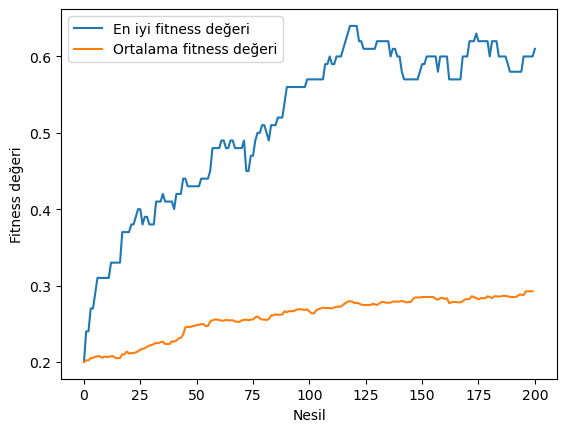

In [204]:
# Parametreler
population_size = [1, 5, 10, 20]
max_generations = [200]
mutation_rate = [0.2, 0.8]
crossover_rate = [0.2, 0.8]

# Genetik algoritmayı çalıştırma
experiment(population_size, max_generations, mutation_rate, crossover_rate, elitism=False)